In [1]:
import pandas as pd
import numpy as np

# Load your data from the CSV file
data = pd.read_csv('final_dataset_with_engineered_features.csv')

# Create RFMS score
# Assuming recency, frequency, monetary, and seniority columns are derived from your existing columns
data['recency'] = np.random.randint(1, 100, size=len(data))  # Example logic
data['frequency'] = data['TransactionCount']
data['monetary'] = data['TotalTransactionAmount']
data['seniority'] = 2025 - data['TransactionYear']

data['rfms_score'] = data['recency'] * 0.2 + data['frequency'] * 0.3 + data['monetary'] * 0.4 + data['seniority'] * 0.1

# Display the first few rows of the dataset
data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,ProductCategory_utility_bill,TotalTransactionAmount,AvgTransactionAmount,TransactionCount,StdDevTransactionAmount,recency,frequency,monetary,seniority,rfms_score
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,0.0,109921.75,923.712185,119,3042.294251,61,119,109921.75,7,44017.30
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,0.0,109921.75,923.712185,119,3042.294251,95,119,109921.75,7,44024.10
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,0.0,1000.00,500.000000,2,0.000000,29,2,1000.00,7,407.10
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,1.0,228727.20,6019.136842,38,17169.241610,76,38,228727.20,7,91518.18
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,0.0,228727.20,6019.136842,38,17169.241610,49,38,228727.20,7,91512.78


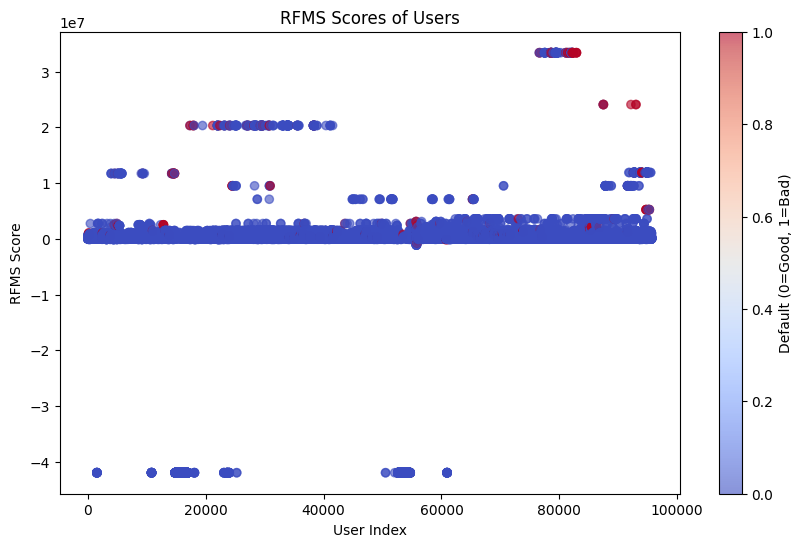

In [2]:
import matplotlib.pyplot as plt

# Assuming 'FraudResult' is the column representing default status
# Adjust the column name if 'default' is different in your dataset
default_column = 'FraudResult'  # Replace this with the correct column name if needed

# Scatter plot of RFMS scores
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['rfms_score'], c=data[default_column], cmap='coolwarm', alpha=0.6)
plt.xlabel('User Index')
plt.ylabel('RFMS Score')
plt.title('RFMS Scores of Users')
plt.colorbar(label='Default (0=Good, 1=Bad)')
plt.show()

# Establish a boundary for classification
# For example, let's set the boundary at the median RFMS score
boundary = data['rfms_score'].median()

# Assign good and bad labels
data['label'] = np.where(data['rfms_score'] > boundary, 'good', 'bad')


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

# Function to calculate Weight of Evidence (WoE)
def calc_woe(df, feature, target):
    df_woe = df.groupby(feature)[target].agg(['count', 'sum'])
    df_woe.columns = ['n', 'bad']
    df_woe['good'] = df_woe['n'] - df_woe['bad']
    df_woe['bad_prop'] = df_woe['bad'] / df_woe['bad'].sum()
    df_woe['good_prop'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['woe'] = np.log(df_woe['good_prop'] / df_woe['bad_prop'])
    return df_woe['woe']

# Discretize the features into bins
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
data_binned = est.fit_transform(data[['recency', 'frequency', 'monetary', 'seniority']])

data_binned = pd.DataFrame(data_binned, columns=['recency_bin', 'frequency_bin', 'monetary_bin', 'seniority_bin'])

# Assuming 'FraudResult' is the column representing default status
# Adjust the column name if 'default' is different in your dataset
default_column = 'FraudResult'  # Replace this with the correct column name if needed

# Calculate WoE for each binned feature
for feature in ['recency_bin', 'frequency_bin', 'monetary_bin', 'seniority_bin']:
    data_binned[f'{feature}_woe'] = calc_woe(data_binned.join(data[[default_column]]), feature, default_column)

# Display the transformed data with WoE
data_binned.head()


,recency_bin,frequency_bin,monetary_bin,seniority_bin,recency_bin_woe,frequency_bin_woe,monetary_bin_woe,seniority_bin_woe
0,6.0,0.0,5.0,9.0,-0.019099,-0.188801,inf,-0.198862
1,9.0,0.0,5.0,9.0,0.014943,1.867976,NaN,NaN
2,2.0,0.0,5.0,9.0,-0.288806,NaN,NaN,NaN
3,7.0,0.0,5.0,9.0,0.024852,NaN,NaN,NaN
4,4.0,0.0,5.0,9.0,0.242760,inf,NaN,NaN
